In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSSB'
m='TOBS'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|    13|[30 55 30 55 30 5...|1904.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     3|[28 58 28 58 00 5...|1948.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|    10|[A0 56 40 56 40 5...|1949.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     8|[A0 56 40 56 00 5...|1950.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       TOBS|USC00047880|     7|[28 58 F0 56 00 5...|1951.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

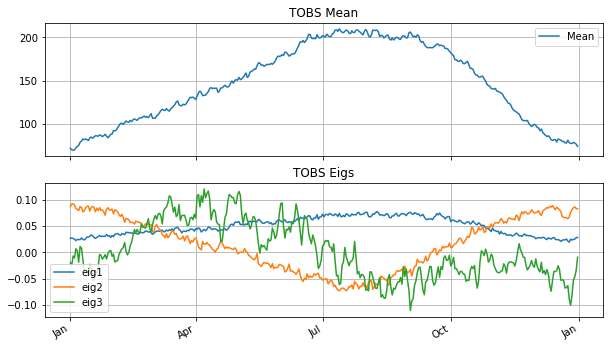

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

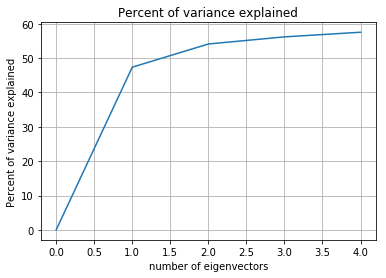

In [134]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:5]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()
dfx=df2.filter(df2.res_2>1).sort(df2.coeff_2)
print dfx.count()


before filter 1186
after filter 1186
26


In [12]:
# def count_zero_snow(row):
#     Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
#     f = np.nan_to_num(Series)
#     s = np.dot(f, f)
#     if s != 0:
#         return (1,1)
#     else:
#         return (0,1)
    
# rdd10=df.rdd.map(count_zero_snow).reduceByKey(lambda x,y:x+y)
# print rdd10.collect()
# #df10=sqlContext.createDataFrame(rdd10)
# #print df10.take(3)

# #count the number of entries where the total_var is zero
# df2.filter(df2.total_var==0).count()    


In [13]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [150]:
def plot_single(feat,func):
    j=0
    fig,X=subplots(1,1,figsize=(8,6))
    #axes=X.reshape(1)
    
    axis = X

    func(feat,fig,axis)
        
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    if len(rows) <=4:
        column_n= len(rows); row_n=1; figsize = (15,5)
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='c2=%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['coeff_2'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            if row_n == 1:
                plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
            else:
                plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
            if k == len(rows):
                return None
    return None


In [37]:
#Find the residual values that are more than 1. These are due to some computation errors. We should
dfx=df3.filter(df3.res_2>1).sort(df3.res_2, ascending=False)
print dfx.count()

dfx.select('res_mean','res_1','res_2','res_3').show(3)

26
+--------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|
+--------------------+------------------+------------------+------------------+
| 0.03956156108343213|1.8073680502046356|1.8333572285415096| 1.840181186845419|
|0.039650058871144506|1.5532654221267856|1.6709456944840664|1.9024572942229399|
|0.051929570597143364|1.4694535917490184|1.6136988551064246| 1.597070579524294|
+--------------------+------------------+------------------+------------------+
only showing top 3 rows



#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

### Understanding the impact of smaller/larger coefficients on reconstruction

In [117]:
#Plot reconstructions with smaller coefficient-1 values
df4=df3.filter(df3.res_2<.4).sort(df3.coeff_1, ascending=False)
print "Top-3 Large Positive Coefficients of First Eigenvector"
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(3);
df4=df3.filter(df3.res_2<.4).sort(df3.coeff_1)
print "Bottom-3 Large Negative Coefficients of First Eigenvector"
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(3);
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_1,ascending=False)
df5 = df5.filter(df5.coeff_1<100)
df5 = df5.filter(df5.coeff_1>-200)
rows=df5.take(12)
print "Coefficients close to zero"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show();

Top-3 Large Positive Coefficients of First Eigenvector
+------------------+-------------------+-------------------+-------------------+------------------+
|           coeff_1|              res_1|            coeff_2|              res_2|           coeff_3|
+------------------+-------------------+-------------------+-------------------+------------------+
|1600.8233347183716|0.18110568276816943|-176.11992131318692|0.17119375769785602|-69.56225107185747|
|1522.1411176160586|0.21010902351347288| -2.233927401029963| 0.2101004523910069|-90.86314817386612|
|1492.3880631030972|0.20736114514707674|-173.87588330728252| 0.1976314126495459| 66.74430080620606|
+------------------+-------------------+-------------------+-------------------+------------------+
only showing top 3 rows

Bottom-3 Large Negative Coefficients of First Eigenvector
+-------------------+-------------------+-------------------+-------------------+-------------------+
|            coeff_1|              res_1|            coeff_2

In [119]:
#Plot reconstructions with smaller coefficient-1 values
df4=df3.filter(df3.res_2<.4).sort(df3.coeff_1)
print df4.count()
rows=df4.take(3)
print "Bottom-3 Large Negative Coefficients of First Eigenvector"
df4.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(3)


370
Bottom-3 Large Negative Coefficients of First Eigenvector
+-------------------+-------------------+-------------------+-------------------+-------------------+
|            coeff_1|              res_1|            coeff_2|              res_2|            coeff_3|
+-------------------+-------------------+-------------------+-------------------+-------------------+
|-1396.0436808199297|0.16874916074519997|-184.88031485486445|0.15417057395463943| -94.30371763301639|
|-1375.1476061138799|0.18118236245860855| -208.9237802007614| 0.1621197898075405|  11.02750239756792|
| -1362.573123106592| 0.1409721361121301|-116.02632202133444| 0.1347433894740833|-110.61898341800746|
+-------------------+-------------------+-------------------+-------------------+-------------------+
only showing top 3 rows



In [120]:
df4.select('elevation','latitude','longitude', 'station','year','total_var','res_2').show(3)
#df4.select('station','year','total_var','coeff_2','res_2').show()

+---------+--------+---------+-----------+------+---------+-------------------+
|elevation|latitude|longitude|    station|  year|total_var|              res_2|
+---------+--------+---------+-----------+------+---------+-------------------+
|      3.7| 37.9994|-121.3178|USC00048560|1942.0|2742470.0|0.15417057395463943|
|      3.7| 37.9994|-121.3178|USC00048560|1943.0|2807394.0| 0.1621197898075405|
|      3.7| 37.9994|-121.3178|USC00048560|1944.0|2778459.0| 0.1347433894740833|
+---------+--------+---------+-----------+------+---------+-------------------+
only showing top 3 rows



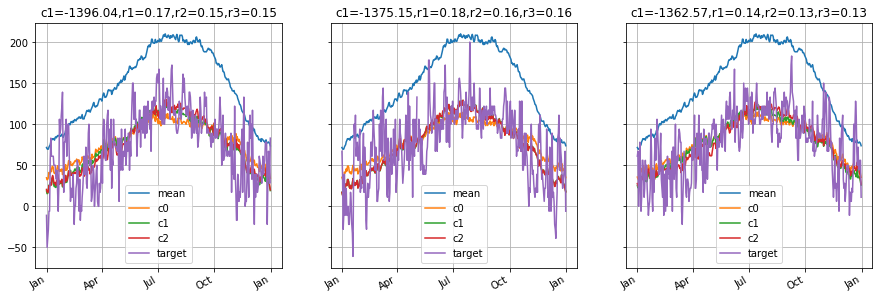

In [121]:
plot_recon_grid(rows)

In [122]:
#Plot reconstructions with larger coefficient-1 values
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_1,ascending=False)
rows=df5.take(3)
print "Top-3 Large Positive Coefficients of First Eigenvector"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(3)

Top-3 Large Positive Coefficients of First Eigenvector
+------------------+-------------------+-------------------+-------------------+------------------+
|           coeff_1|              res_1|            coeff_2|              res_2|           coeff_3|
+------------------+-------------------+-------------------+-------------------+------------------+
|1600.8233347183716|0.18110568276816943|-176.11992131318692|0.17119375769785602|-69.56225107185747|
|1522.1411176160586|0.21010902351347288| -2.233927401029963| 0.2101004523910069|-90.86314817386612|
|1492.3880631030972|0.20736114514707674|-173.87588330728252| 0.1976314126495459| 66.74430080620606|
+------------------+-------------------+-------------------+-------------------+------------------+
only showing top 3 rows



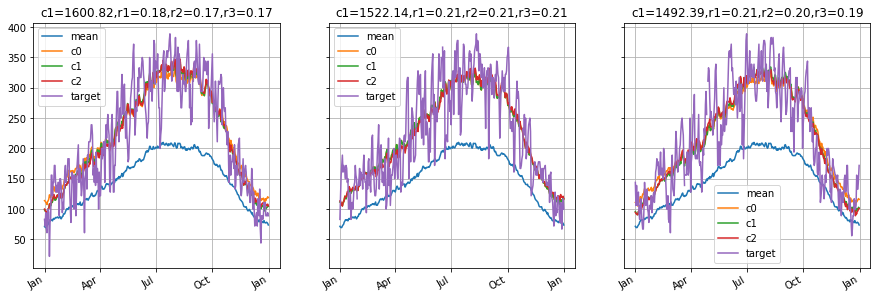

In [123]:
plot_recon_grid(rows)

In [124]:
#Plot reconstructions with coefficient-1 that are close to zero (in the range of (100 and -200) )
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_1,ascending=False)
df5 = df5.filter(df5.coeff_1<100)
df5 = df5.filter(df5.coeff_1>-200)
print df5.count()
rows=df5.take(12)
print "Coefficients close to zero"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show()


3
Coefficients close to zero
+-------------------+------------------+------------------+-------------------+------------------+
|            coeff_1|             res_1|           coeff_2|              res_2|           coeff_3|
+-------------------+------------------+------------------+-------------------+------------------+
|-135.83566761117564|0.9614246271108519|462.50001900239977|   0.35542195470675|21.283201069339043|
|-168.78218404317622|0.9663507302039507| 561.0962743275245|0.34011703254204867| 90.66135387451129|
|-199.47365751263615|0.8937022097551267|  453.357141396449|0.34462419212943557|-16.35381284837164|
+-------------------+------------------+------------------+-------------------+------------------+



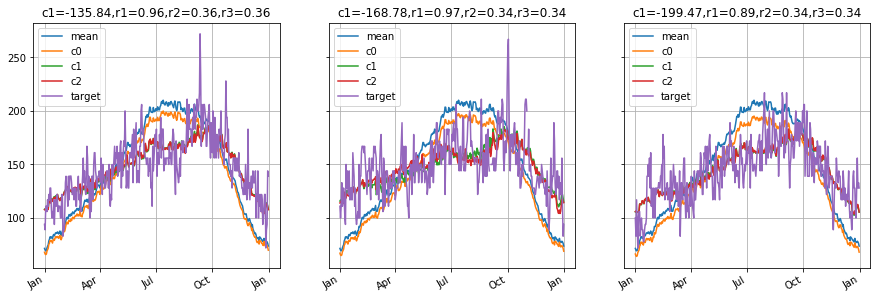

In [125]:
plot_recon_grid(rows)

In [151]:
#Plot reconstructions with coefficient-1 that are close to zero (in the range of (100 and -200) )
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
#df5 = df5.filter(df5.coeff_1<+500)
#df5 = df5.filter(df5.coeff_1>-500)
print df5.count()
rows=df5.take(3)
print "Coefficients close to zero"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(5)


370
Coefficients close to zero
+-------------------+------------------+-----------------+-------------------+-------------------+
|            coeff_1|             res_1|          coeff_2|              res_2|            coeff_3|
+-------------------+------------------+-----------------+-------------------+-------------------+
|-347.45820482978087|0.9585079816745837| 589.325280488715|0.37559921942381225| 1.8806876157562973|
|   603.434097232574|0.5975537661854835|564.5300962958033|0.36964136068871584|-181.71364633851724|
|-168.78218404317622|0.9663507302039507|561.0962743275245|0.34011703254204867|  90.66135387451129|
|  -302.763390638963| 0.844052452987099|550.5773382528388| 0.3283389637632928| -78.88867510506248|
| -361.5351445148436|0.8470058927530103| 550.481851592606| 0.2514794774421284|  30.20486920129719|
+-------------------+------------------+-----------------+-------------------+-------------------+
only showing top 5 rows



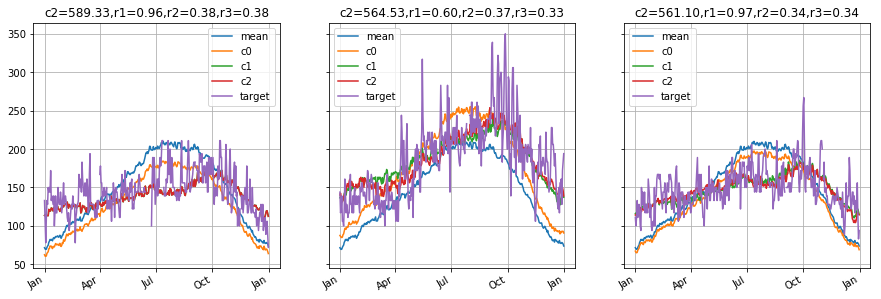

In [152]:
plot_recon_grid(rows)

370
Coefficients close to zero
+------------------+-------------------+-------------------+-------------------+-------------------+
|           coeff_1|              res_1|            coeff_2|              res_2|            coeff_3|
+------------------+-------------------+-------------------+-------------------+-------------------+
|-861.0334416567524|0.46355258931629584|  -549.631305052322|0.26326372771410966| 184.71887749552727|
| -642.702488138018| 0.6335975369599235| -513.2322420484589|0.39994726804281927|  37.57120536085576|
|-929.4472172484665| 0.4448499842735538|-475.64342101208194|0.38790964632836905| 202.73230356804058|
|-700.7483970756183| 0.6080129378253386| -475.5074679144002|0.39949779833614063| -33.69350107120182|
|-581.7469789071072| 0.5952631916527034|  -466.772903618972| 0.3346984170757564|-11.239233822591961|
+------------------+-------------------+-------------------+-------------------+-------------------+
only showing top 5 rows



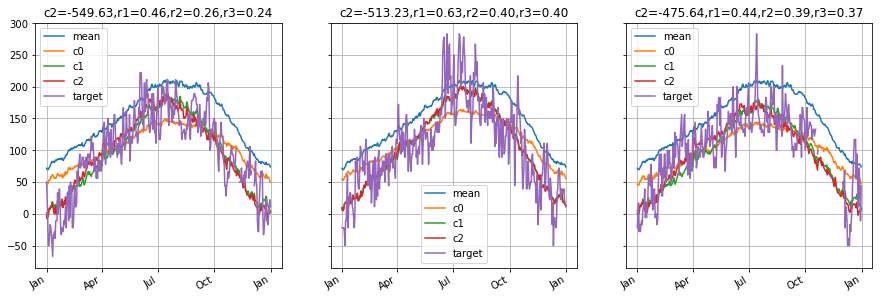

In [153]:
#Plot reconstructions with coefficient-1 that are close to zero (in the range of (100 and -200) )
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=True)
#df5 = df5.filter(df5.coeff_1<+500)
#df5 = df5.filter(df5.coeff_1>-500)
print df5.count()
rows=df5.take(3)
print "Coefficients close to zero"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(5)
plot_recon_grid(rows)

730
Coefficients close to zero
+------------------+-------------------+-------------------+-------------------+-------------------+
|           coeff_1|              res_1|            coeff_2|              res_2|            coeff_3|
+------------------+-------------------+-------------------+-------------------+-------------------+
|1044.2730412205478|0.40415977339119846|-196.43431094948141|0.38307658047127874|-471.17456169717883|
| 593.5873919170689| 0.5431904197219658|  535.0722416575384|0.42995855046743436| -465.7834911555432|
| 963.3701728428938|0.48409182139674506|-374.21991762577835| 0.4062451910310502|-458.15920512583466|
|1119.5127339142036| 0.3054088805633925| -147.7692990079543|0.31248906154971623| -444.0002697947692|
| 328.6677691230769| 0.7443162367599616| 279.41628238270414| 0.5669980488408347|  -405.351522522566|
+------------------+-------------------+-------------------+-------------------+-------------------+
only showing top 5 rows



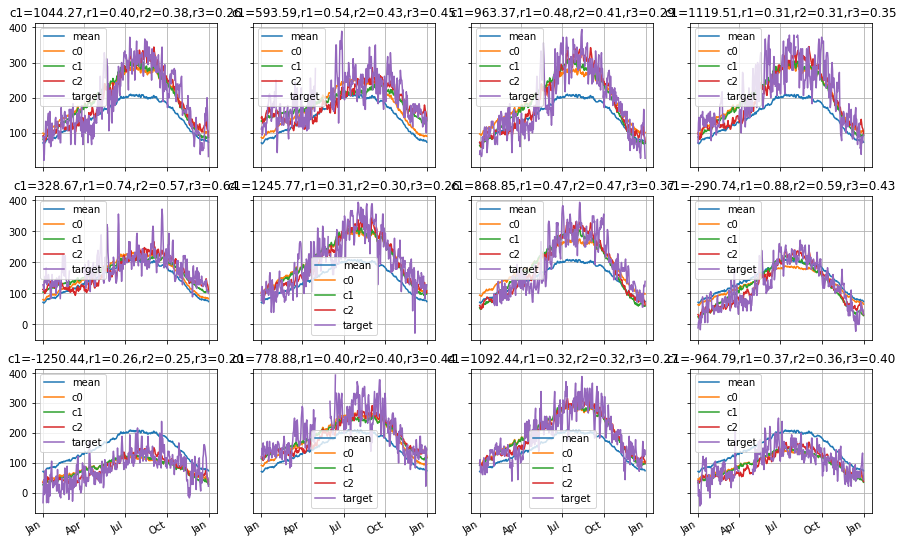

In [143]:
#Plot reconstructions with coefficient-1 that are close to zero (in the range of (100 and -200) )
df5=df3.filter(df3.res_2<0.6).sort(df3.coeff_3,ascending=True)
#df5 = df5.filter(df5.coeff_1<+500)
#df5 = df5.filter(df5.coeff_1>-500)
print df5.count()
rows=df5.take(12)
print "Coefficients close to zero"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(5)
plot_recon_grid(rows)

730
Coefficients close to zero
+------------------+-------------------+-------------------+-------------------+-----------------+
|           coeff_1|              res_1|            coeff_2|              res_2|          coeff_3|
+------------------+-------------------+-------------------+-------------------+-----------------+
| 605.5343752928358| 0.5129735645906801| 332.12621885512687| 0.5684305440290792|668.9679949044637|
|1164.7190773954503|0.23425724229553946| 145.20913259561183|0.24995360020047847|476.8338527680747|
| 945.8746284798422| 0.2902216766157093| -233.2788346273577| 0.2797158652683738|372.0931522351538|
|1384.3170563206556|0.24115595157056324|-211.64994676966217|0.22460579693216912|343.7487850466382|
|1212.7243865016278| 0.3411680227370879|-319.86100349409287| 0.2836125744630265|334.7541313239362|
+------------------+-------------------+-------------------+-------------------+-----------------+
only showing top 5 rows



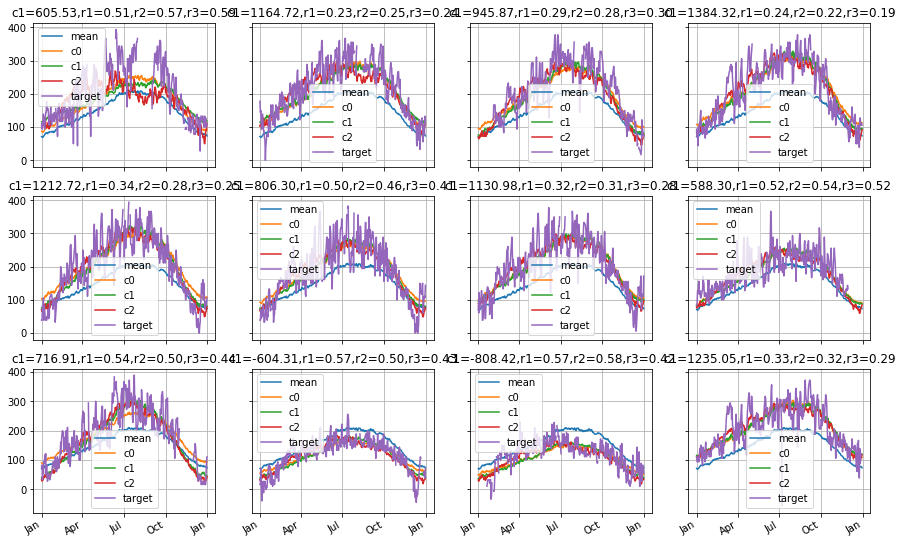

In [144]:
#Plot reconstructions with coefficient-1 that are close to zero (in the range of (100 and -200) )
df5=df3.filter(df3.res_2<0.6).sort(df3.coeff_3,ascending=False)
#df5 = df5.filter(df5.coeff_1<+500)
#df5 = df5.filter(df5.coeff_1>-500)
print df5.count()
rows=df5.take(12)
print "Coefficients close to zero"
df5.select('coeff_1','res_1','coeff_2','res_2','coeff_3').show(5)
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

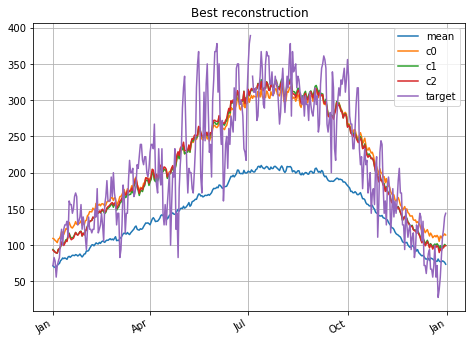

In [126]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_1,ascending=False)
rows=df5.take(12)
row=rows[10]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
#print 'residual normalized norm  after mean:',res[0]
#print 'residual normalized norm  after mean + top eigs:',res[1:]
#print "coef: ", coeff

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [24]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    print 'val:', len(vals)
    print max(vals)
    print min(vals)
    #P=np.arange(0,(1+1./(len(vals))),1./(len(vals)))
    #P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    P=np.arange(0,1,1./(len(vals)))
    print 'val:', len(vals)
    print P.shape



    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

val: 1186
1.90245729422
0.117321382371
val: 1187
(1187,)


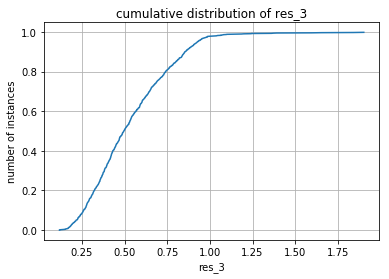

In [133]:
plot_CDF('res_3')

val: 1186
1.8073680502
0.127339156276
val: 1187
(1187,)


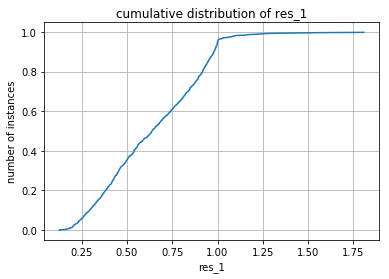

In [132]:
plot_CDF('res_1')

val: 1186
1600.82333472
-1396.04368082
val: 1187
(1187,)


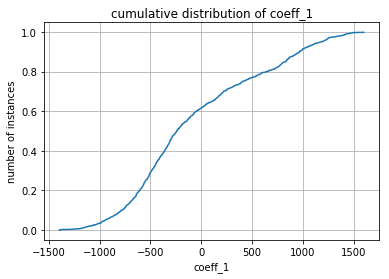

In [131]:
plot_CDF('coeff_1')

In [28]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [29]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.1M	../../Data/Weather/US_Weather_SSSBSSSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_PRCP.parquet
216K	../../Data/Weather/decon_SSSBSSSB_SNWD.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_TOBS.parquet
